In [1]:
from input_preprocess import tokenizer
from lwm_model import lwm
import torch
import numpy as np

# 选择数据集
scenario_names = np.array([
    "city_18_denver", "city_15_indianapolis", "city_19_oklahoma",
    "city_12_fortworth", "city_11_santaclara", "city_7_sandiego"
])
scenario_idxs = np.array([0, 1, 2, 3, 4, 5])  # Select the scenario indexes
selected_scenario_names = scenario_names[scenario_idxs]

In [2]:
# 对数据进行标记
preprocessed_chs = tokenizer(
    selected_scenario_names=selected_scenario_names,  # Selects predefined DeepMIMOv3 scenarios_test. Set to None to load your own dataset.
    manual_data=None,  # If using a custom dataset, ensure it is a wireless channel dataset of size (N,32,32) based on the settings provided above.
    gen_raw=True  # Set gen_raw=False to apply masked channel modeling (MCM), as used in LWM pre-training. For inference, masking is unnecessary unless you want to evaluate LWM's ability to handle noisy inputs.
)


Basestation 3

UE-BS Channels
/Users/dianhongyang/Desktop/毕业设计/LWM_MODEL/LWM/scenarios/city_18_denver/BS3_UE_0-6970.mat


Generating channels: 100%|██████████| 6970/6970 [00:00<00:00, 41446.69it/s]



Basestation 3

UE-BS Channels
/Users/dianhongyang/Desktop/毕业设计/LWM_MODEL/LWM/scenarios/city_15_indianapolis/BS3_UE_0-6320.mat


Generating channels: 100%|██████████| 6320/6320 [00:00<00:00, 13884.68it/s]



Basestation 1

UE-BS Channels
/Users/dianhongyang/Desktop/毕业设计/LWM_MODEL/LWM/scenarios/city_19_oklahoma/BS1_UE_0-6150.mat


Generating channels: 100%|██████████| 6150/6150 [00:00<00:00, 11723.19it/s]



Basestation 1

UE-BS Channels
/Users/dianhongyang/Desktop/毕业设计/LWM_MODEL/LWM/scenarios/city_12_fortworth/BS1_UE_0-6192.mat


Generating channels: 100%|██████████| 6192/6192 [00:00<00:00, 21329.56it/s]



Basestation 1

UE-BS Channels
/Users/dianhongyang/Desktop/毕业设计/LWM_MODEL/LWM/scenarios/city_11_santaclara/BS1_UE_0-5358.mat


Generating channels: 100%|██████████| 5358/5358 [00:00<00:00, 15308.05it/s]



Basestation 1

UE-BS Channels
/Users/dianhongyang/Desktop/毕业设计/LWM_MODEL/LWM/scenarios/city_7_sandiego/BS1_UE_0-5893.mat


Processing items: 100%|██████████| 14840/14840 [00:00<00:00, 29245.59it/s]


In [3]:
# 加载模型
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Loading the LWM model on {device}...")
model = lwm.from_pretrained(device=device)

Loading the LWM model on cpu...
Model loaded successfully from /Users/dianhongyang/Desktop/毕业设计/LWM_Model/LWM/model_weights.pth to cpu


/Users/dianhongyang/Desktop/毕业设计/LWM_Model/LWM/lwm_model.py:123: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_location=devic

In [4]:
# 进行推理
from inference import lwm_inference, create_raw_dataset
input_types = ['cls_emb', 'channel_emb', 'raw']
selected_input_type = input_types[0]  # Change the index to select LWM CLS embeddings, LWM channel embeddings, or the original input channels.

if selected_input_type in ['cls_emb', 'channel_emb']:
    dataset = lwm_inference(preprocessed_chs, selected_input_type, model, device)
else:
    dataset = create_raw_dataset(preprocessed_chs, device)

LWM loss: 0.0193


In [5]:
# preprocessed_chs 是一个列表,每个元素包含3个部分:
# 1. input_ids: 形状为(1026,32) 的数组
#    - 第一列(0)是[CLS]标记,值为0.2
#    - 剩余1025列是信道数据,每列代表一个信道特征
#    - 32行代表32个子载波

# 2. masked_tokens: 形状为(M,32)的数组,其中M是被mask的token数量
#    - 存储了被mask位置的原始值
#    - 用于计算mask预测的损失

# 3. masked_pos: 形状为(M,)的数组
#    - 记录了哪些位置被mask
#    - 值范围是0到1025之间的整数索引

# 打印第一个样本的形状信息
print("第一个样本的input_ids形状:", np.array(preprocessed_chs[0][0]).shape)
print("第一个样本的masked_tokens形状:", np.array(preprocessed_chs[0][1]).shape) 
print("第一个样本的masked_pos形状:", np.array(preprocessed_chs[0][2]).shape)

第一个样本的input_ids形状: (129, 16)
第一个样本的masked_tokens形状: (18, 16)
第一个样本的masked_pos形状: (18,)


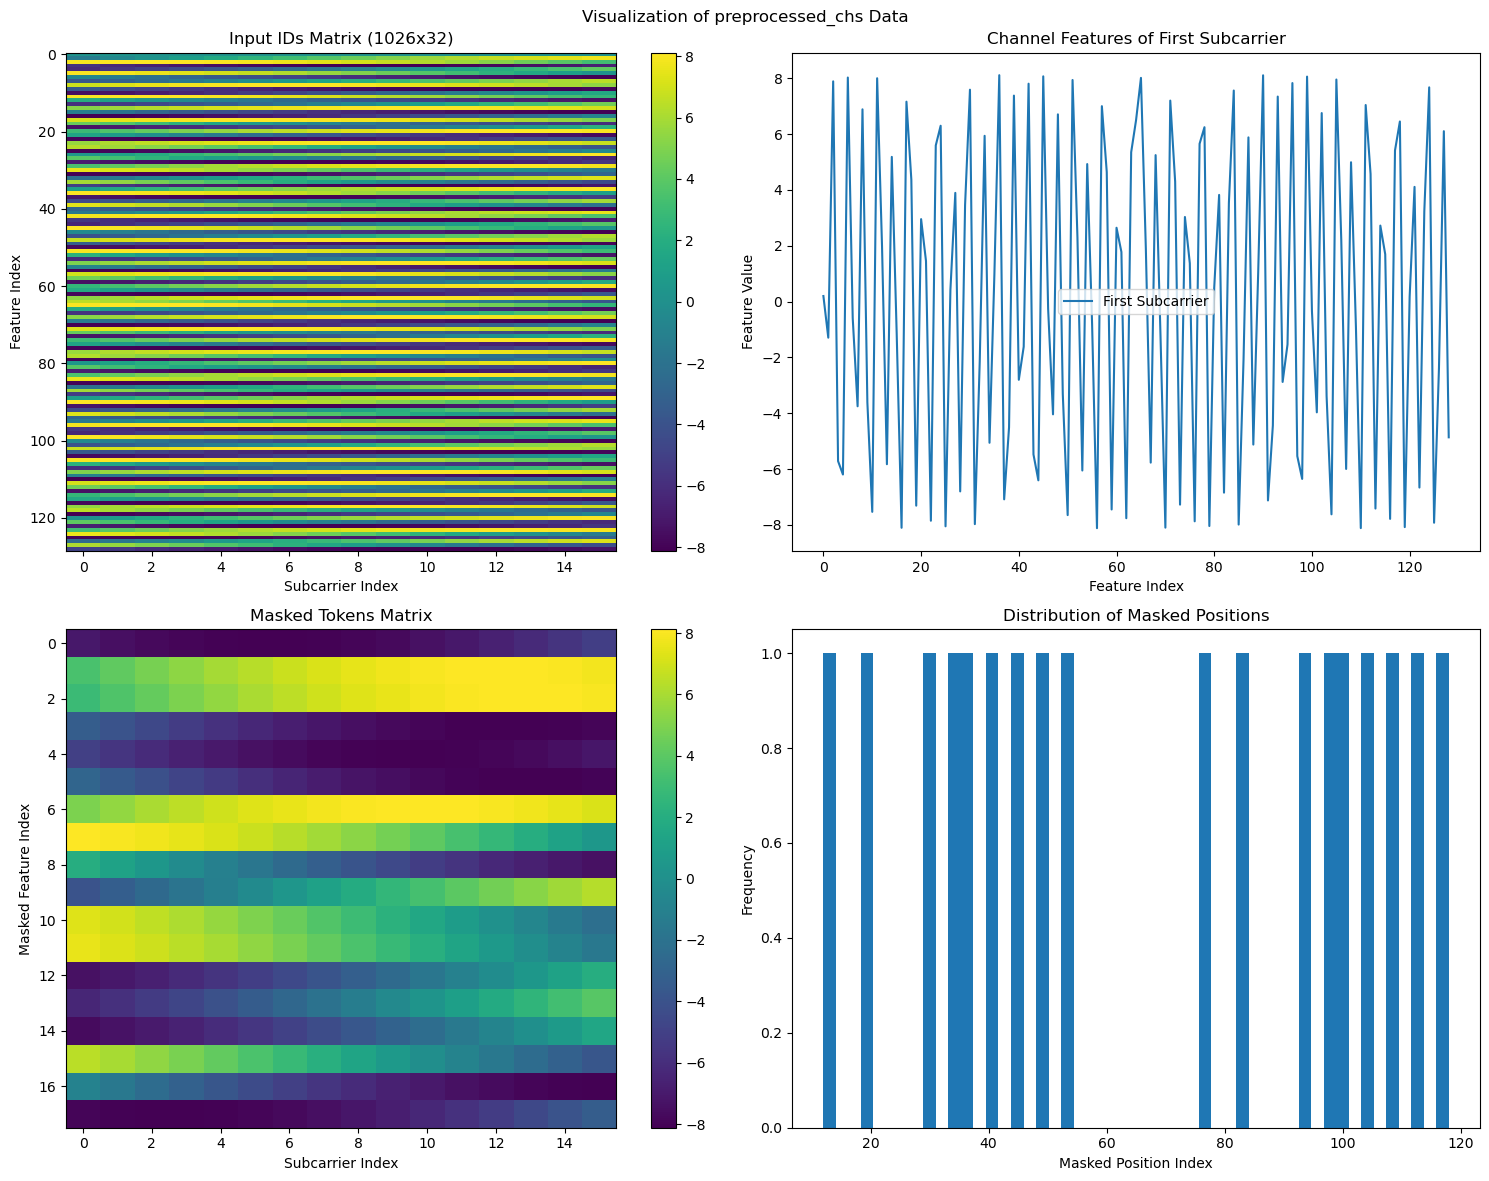

In [6]:
# 可视化preprocessed_chs数据
import matplotlib.pyplot as plt
import numpy as np

# Visualize the first sample data
sample = preprocessed_chs[0]
input_ids = np.array(sample[0])
masked_tokens = np.array(sample[1]) 
masked_pos = np.array(sample[2])

# Create a 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Visualization of preprocessed_chs Data')

# 1. Visualize input_ids matrix
im0 = axes[0,0].imshow(input_ids, aspect='auto', cmap='viridis')
axes[0,0].set_title('Input IDs Matrix (1026x32)')
axes[0,0].set_xlabel('Subcarrier Index')
axes[0,0].set_ylabel('Feature Index')
plt.colorbar(im0, ax=axes[0,0])

# 2. Visualize channel features of first subcarrier
axes[0,1].plot(input_ids[:,0], label='First Subcarrier')
axes[0,1].set_title('Channel Features of First Subcarrier')
axes[0,1].set_xlabel('Feature Index')
axes[0,1].set_ylabel('Feature Value')
axes[0,1].legend()

# 3. Visualize masked_tokens matrix
im1 = axes[1,0].imshow(masked_tokens, aspect='auto', cmap='viridis')
axes[1,0].set_title('Masked Tokens Matrix')
axes[1,0].set_xlabel('Subcarrier Index')
axes[1,0].set_ylabel('Masked Feature Index')
plt.colorbar(im1, ax=axes[1,0])

# 4. Visualize masked_pos distribution
axes[1,1].hist(masked_pos, bins=50)
axes[1,1].set_title('Distribution of Masked Positions')
axes[1,1].set_xlabel('Masked Position Index')
axes[1,1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()
